# Part 2: Transfer

Deep neural networks learn representations of data that can be helpful for related but different tasks than that for which they were originally trained. This is a valuable property, because it suggests that some of the representation learning can be **transferred** to a different related task. This is called **transfer learning.**

In this part of the assignment, you will load a pre-trained neural network originally trained for one image recognition task and will apply and fine tune that model for a related but different image recognition task on a different dataset, all using PyTorch. 

Specifically, we will use a pretrained ResNet model (a deep convolutional neural network with residual connections to improve training stability) to classify 32 by 32 pixel color images of animals, automobiles, planes, and ships (with 10 classes in total).

**Learning objectives.** You will:

1. Use a deep ResNet convolutional neural network architecture for an image recognition task
2. Apply a pre-trained ResNet model for a related but different image recognition task by retraining the final decision layer.
3. Apply transfer learning with feature extraction and fine-tuning to transfer a pre-trained model to improve model performance on a new task.

While it is possible to complete this part using CPU compute, it may be very slow. To accelerate your training, you are strongly encouraged to use GPU compute resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

The following code imports relevant PyTorch modules, downloads the dataset, splits into a train, validation, and test dataset, and prepares PyTorch dataloaders for batching.

In [2]:
# Run but DO NOT MODIFY this code

# Import libraries
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=ToTensor())
train_set, val_set = random_split(train_data, [0.8, 0.2])
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=ToTensor())

# Prepare DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

The following code then visualizes some random examples of the training data.

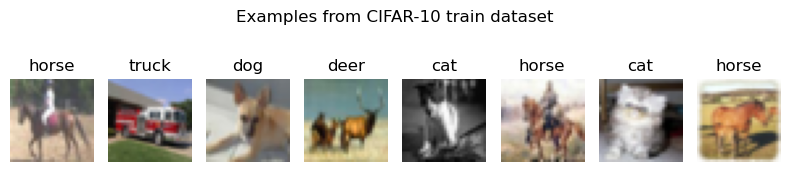

In [4]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
"horse", "ship", "truck"]

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True))
images, labels = next(dataiter)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 8, figsize=(8, 2))
fig.suptitle('Examples from CIFAR-10 train dataset', fontsize=12)

# Plot 8 images
for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.set_title(f"{classes[labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Run but DO NOT MODIFY this code

from matplotlib import pyplot as plt

# Helper function to visualize performance during training
def plot_training_curves(train_losses, val_accuracies):
    """Plot training loss and validation accuracy curves.
    
    Parameters
    ----------
    train_losses : list of float
        Training loss values for each epoch. Should have one value per epoch.
    val_accuracies : list of float
        Validation accuracy values for each epoch. Should have same length as
        train_losses. Accuracy values should be between 0 and 1 (or 0 and 100
        if using percentages).
        
    Returns
    -------
    None
        Displays matplotlib figure with two subplots showing training curves.
        
    Examples
    --------
    >>> train_losses = [0.8, 0.6, 0.4, 0.3, 0.2]
    >>> val_accuracies = [0.75, 0.80, 0.85, 0.87, 0.88]
    >>> plot_training_curves(train_losses, val_accuracies)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

## Task 1

The following code imports a pretrained ResNet model that was trained to classify color images on the ImageNet dataset. The images in that dataset represent 1,000 possible classes. By contrast, the images in our dataset are classified into one of just 10 classes.

### Transfer Learning by Feature Extraction

Unsurprisingly, you will find that you cannot directly apply the ResNet model to prediction on our CIFAR-10 dataset. However, we can achieve surprising performance by **only changing the output layer** of the model, leaving all parameters prior to the final layer unchanged. This approach to transfer learning is often called **feature extraction** because we are essentially just training a new classifier on top of learned features extracted from the preexisting model's representation. This tends to work because pre-trained deep model architectures learn hiearchical features, for example:
  - Early layers: edges, textures, basic patterns
  - Middle layers: object parts, shapes
  - Late layers: high-level, task-specific features

By freezing early layers and only training the final classifier, we leverage powerful feature representations learned on ImageNet while adapting to our specific task on CIFAR-10.

### What to do

1. Freeze all of the existing ResNet model parameters. You can do this by setting `requires_grad = False` for each element of the iterable [`model.parameters()`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters). 

2. Replace the final `.fc` layer of the ResNet architecture with a fully connected [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with just 10 output units. This will be the new classification layer we train on top of the existing ResNet features.

3. Train your model to minimize the [Cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) on the training data. We recommend that you use GPU compute to accelerate training.
  - Use the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) that implements standard minibatch stochastic gradient descent, or the [Adam optimizer](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html).
  - Evaluate and record the training loss and validation accuracy once per epoch so that you can visualize training performance using the `plot_training_curves` function defined above.
  - Implement early stopping so that your model stops training after the validation accuracy is no longer improving. You are not required to use any particular patience hyperparameter. You may also want to set a maximum number of epochs (e.g., 10 or 20) to ensure that the code terminates in a reasonable amount of time even if training hyperparameters are suboptimal.
  - Note that the `train_loader` and `val_loader` defined above can be used for automatic batching and shuffling the training and validation data during training.

**Your goal is to achieve a validation accuracy of 40% or better without training anything but the final classification layer.** 40% may seem like poor performance -- Note that there are ten classes so random guessing with balanced data would only achieve 10% accuracy in expectation.

Once you reach this goal, **report the following:**
  - Use the `plot_training_curves` function to visualize the training results
  - Evaluate your trained model on the held out test set (see `test_loader` above), and report the test accuracy.

mps Epoch 1 : Training Loss 1.8769946363449097 | Validation Accuracy 0.4145
mps Epoch 2 : Training Loss 1.8386095630645751 | Validation Accuracy 0.4204
mps Epoch 3 : Training Loss 1.8391957794189453 | Validation Accuracy 0.4156
mps Epoch 4 : Training Loss 1.8367246475219727 | Validation Accuracy 0.4071
mps Epoch 5 : Training Loss 1.8496317337036132 | Validation Accuracy 0.4169
The device I used is Apple MPS
The best validation accuracy is 0.4204
The training time is 69.52889919281006
The test accuracy is 0.4119


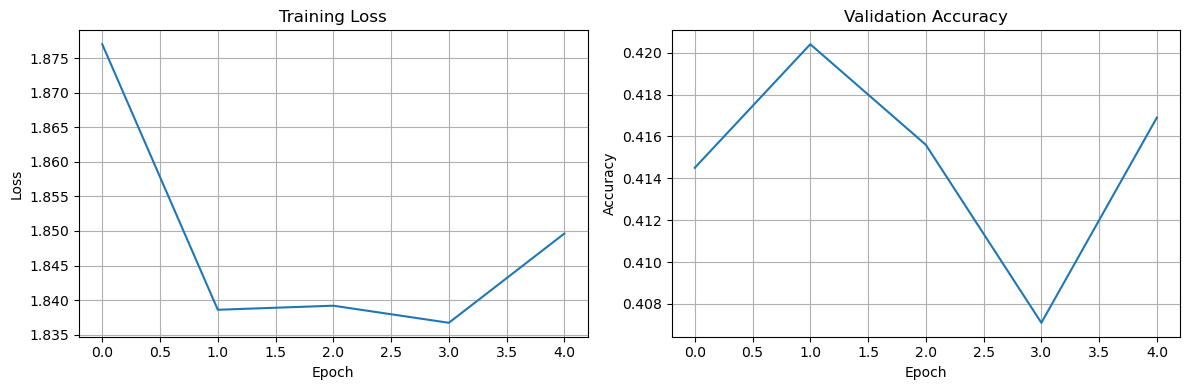

In [7]:
from torchvision import models
import torch.nn as nn
import time
import copy

torch.manual_seed(2025)
model = models.resnet18(weights='DEFAULT')

# Write code to finish task 1 here
device = ""
device_name = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple MPS"
else:
    device = torch.device("cpu")
    device_name = "CPU"
for param in model.parameters():
    param.requires_grad = False
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)
model_one = model.to(device)

def training_resnet(model, train_loader, val_loader, max_epochs = 20, patience = 3, lr = 0.005):
    CEL = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.fc.parameters(), lr = lr)
    s = 0
    best_accuracy = 0.0
    train_losses = []
    val_accuracies = []
    best_model = None
    start_time = time.time()
    for epoch in range(1, max_epochs + 1):
        model.train()
        sum_loss = 0.0
        n_train = 0
        for x, y in train_loader:
            xb = x.to(device)
            yb = y.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = CEL(logits, yb)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * xb.size(0)
            n_train += xb.size(0)
        average_train_loss = sum_loss / n_train
        train_losses.append(average_train_loss)
        model.eval()
        with torch.no_grad():
            correct = 0
            n = 0
            for x, y in val_loader:
                xb = x.to(device)
                yb = y.to(device)
                correct += (model(xb).argmax(1) == yb).sum().item()
                n += yb.size(0)
            val_accuracy = correct / n
            val_accuracies.append(val_accuracy)
        print(device, "Epoch", epoch, ": Training Loss", average_train_loss, "| Validation Accuracy", val_accuracy)
        if val_accuracy > best_accuracy + 0.0001:
            best_accuracy = val_accuracy
            s = 0
            best_model = copy.deepcopy(model).to(device).eval()
        else:
            s += 1
            if s >= patience:
                break
    training_time = time.time() - start_time
    testing_model = best_model if best_model is not None else model
    return testing_model, train_losses, val_accuracies, best_accuracy, training_time
            
@torch.no_grad()
def test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    n = 0
    for x, y in test_loader:
        xb = x.to(device)
        yb = y.to(device)
        correct += (model(xb).argmax(1) == yb).sum().item()
        n += yb.size(0)
        accuracy = correct / n
    return accuracy

testing_model_one, train_losses_one, val_accuracies_one, best_accuracy_one, training_time_one = training_resnet(model_one, train_loader, val_loader)
test_accuracy_one = test_accuracy(testing_model_one, test_loader)
print("The device I used is", device_name)
print("The best validation accuracy is", best_accuracy_one)
print("The training time is", training_time_one)
print("The test accuracy is", test_accuracy_one)
plot_training_curves(train_losses_one, val_accuracies_one)

## Task 2

### Transfer Learning by Fine-Tuning

We can achieve a higher level of performance by **fine-tuning** the entire pre-trained model on the new task. With this method, we start with original pretrained ResNet model and replace the output layer as before, but this time **do not** freeze any of the other parameters. 

This is more computationally expensive than mere feature extraction (we are updating all model parameters rather than merely the final classification layer) but tends to result in better model performance because we modify the model's representation in a way that is specific to this classification data. Conceptually, you can think of the pre-trained ResNet model parameters as establishing a highly informed initialization for training.

### What to do

1.  As before, replace the final `.fc` layer of the ResNet architecture with a fully connected [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with just 10 output units. This will be the new classification layer we train on top of the existing ResNet features. Do NOT freeze any model parameters.

2. Train your model as in Task 1. It is common practice to use a slightly smaller learning rate when fine-tuning. For example, if you used 0.005 above, consider using 0.001 here.

**Your goal is to achieve a validation accuracy of 75% or better**.

Once you reach this goal, **report the following:**
  - Use the `plot_training_curves` function to visualize the training results
  - Evaluate your trained model on the held out test set (see `test_loader` above), and report the test accuracy.

mps Epoch 1 : Training Loss 1.0415507001876831 | Validation Accuracy 0.7041
mps Epoch 2 : Training Loss 0.7051528643131256 | Validation Accuracy 0.7264
mps Epoch 3 : Training Loss 0.5617224365711212 | Validation Accuracy 0.7637
mps Epoch 4 : Training Loss 0.44171556634902953 | Validation Accuracy 0.755
mps Epoch 5 : Training Loss 0.36846328020095825 | Validation Accuracy 0.7799
mps Epoch 6 : Training Loss 0.2953210490345955 | Validation Accuracy 0.7943
mps Epoch 7 : Training Loss 0.23563828179836274 | Validation Accuracy 0.791
mps Epoch 8 : Training Loss 0.1890316222012043 | Validation Accuracy 0.7922
mps Epoch 9 : Training Loss 0.15149894485771656 | Validation Accuracy 0.8008
mps Epoch 10 : Training Loss 0.13202737381607293 | Validation Accuracy 0.7985
mps Epoch 11 : Training Loss 0.12071773296892643 | Validation Accuracy 0.7769
mps Epoch 12 : Training Loss 0.09947385586425662 | Validation Accuracy 0.791
The device I used is Apple MPS
The best validation accuracy is 0.8008
The trainin

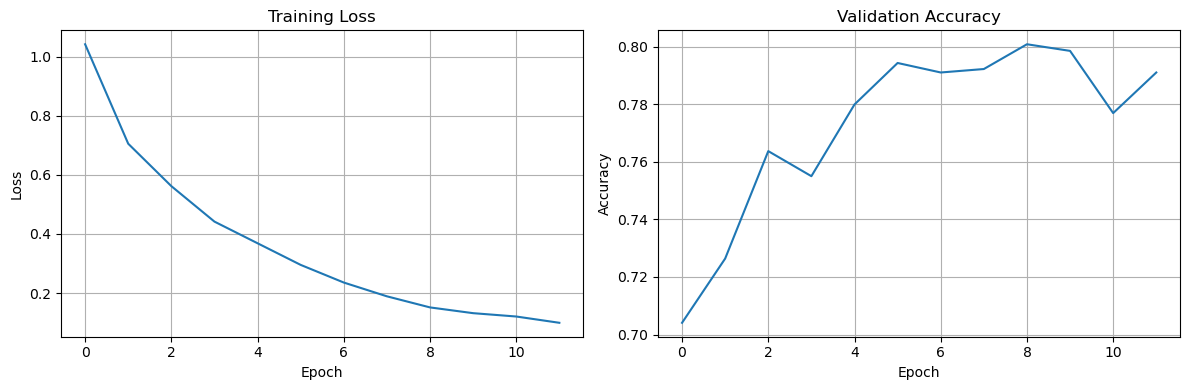

In [9]:
from torchvision import models

torch.manual_seed(2025)
model = models.resnet18(weights='DEFAULT')

# Write code to finish task 2 here
new_in_features = model.fc.in_features
model.fc = nn.Linear(new_in_features, 10)
model_two = model.to(device)

def training_finetune(model, train_loader, val_loader, max_epochs = 20, patience = 3, lr = 0.001):
    CEL = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    s = 0
    best_accuracy = 0.0
    train_losses = []
    val_accuracies = []
    best_model = None
    start_time = time.time()
    for epoch in range(1, max_epochs + 1):
        model.train()
        sum_loss = 0.0
        n_train = 0
        for x, y in train_loader:
            xb = x.to(device)
            yb = y.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = CEL(logits, yb)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * xb.size(0)
            n_train += xb.size(0)
        average_train_loss = sum_loss / n_train
        train_losses.append(average_train_loss)
        model.eval()
        with torch.no_grad():
            correct = 0
            n = 0
            for x, y in val_loader:
                xb = x.to(device)
                yb = y.to(device)
                correct += (model(xb).argmax(1) == yb).sum().item()
                n += yb.size(0)
            val_accuracy = correct / n
            val_accuracies.append(val_accuracy)
        print(device, "Epoch", epoch, ": Training Loss", average_train_loss, "| Validation Accuracy", val_accuracy)
        if val_accuracy > best_accuracy + 0.0001:
            best_accuracy = val_accuracy
            s = 0
            best_model = copy.deepcopy(model).to(device).eval()
        else:
            s += 1
            if s >= patience:
                break
    training_time = time.time() - start_time
    testing_model = best_model if best_model is not None else model
    return testing_model, train_losses, val_accuracies, best_accuracy, training_time

testing_model_two, train_losses_two, val_accuracies_two, best_accuracy_two, training_time_two = training_finetune(model_two, train_loader, val_loader)
test_accuracy_two = test_accuracy(testing_model_two, test_loader)
print("The device I used is", device_name)
print("The best validation accuracy is", best_accuracy_two)
print("The training time is", training_time_two)
print("The test accuracy is", test_accuracy_two)
plot_training_curves(train_losses_two, val_accuracies_two)